In [1]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
%matplotlib inline

In [2]:
def soft_thresh(y, lam):
    #try:
        #n = y.shape[0]
    #except:
        #n=1
    n = y.shape[0]
    return np.sign(y) * np.maximum((np.abs(y) - lam), np.zeros(n))

In [5]:
def ADMM(X, y, b0, z0, u0, rho=5., lam=.1, e_abs = 1e-4, e_rel=1e-2, max_iters=1000):
    '''
    Implement the ADMM algorithm for the lasso.
    
    Inputs
    ----------------------
    X: An NxP sample array, where there are N samples with P features
    y: An N result array
    b0: A P vector, An initial guess for the beta vector
    z0: A P vector, An initial guess for the z vector
    u0: A P vector, An initial guess for the dual variable vector
    rho: float > 0, optional.  The "stepsize" parameter, analogous with the augmented lagrangian
        penalty parameter
    lam: float > 0, optional. The lasso penalty parameter
    e_abs: float > 0, optional. An absolute tolerance used to calculate the stopping 
        criterion.
    e_rel: float > 0, optional. A relative tolerance used to calculate the stopping
        criterion.
    max_iters: Int, optional. The maximum number of iterations for which to run the 
        algorithm
    Outputs
    -----------------------
    z1: The returned coefficient vector
    Z: A list of the z values for each step
    R: A list of the primal residuals
    S: A list of the dual residuals
    Ep: A list of the primal error tolerances at each step
    Ed: A list of the dual error tolerances at each step
    Obj: A list of the objective function values at each iteration
    '''
    # Set various variables
    N,P = X.shape
    sqPe = np.sqrt(P) * e_abs
    Z = [z0]
    #U = [u0]
    R = []
    S = []
    Ep = []
    Ed = []
    Obj = []
    
    mu = 10
    tau_incr = 2
    tau_decr = 2
    
    # Cache reused values for the algorithm
    beta_coef = np.dot(X.T, X) 
    I = np.eye(P)
    X_Ty = np.dot(X.T, y)
    
    z1 = z0
    u1 = u0
    b1 = b0
    
    for i in np.arange(max_iters):
        # Update each vector
        z0 = np.copy(z1)
        b1 = la.solve(beta_coef + rho*I, X_Ty + rho * (z1 - u1))
        z1 = soft_thresh(b1 + u1, lam / rho)
        u1 += b1 - z1
        
        # Calculate the error tolerances
        r = b1 - z1
        s = -rho * (z1 - z0)
        norm_r = la.norm(r)
        norm_s = la.norm(s)
        e_pri = sqPe + e_rel * max(la.norm(b1), la.norm(z1))
        e_dual = sqPe + e_rel * la.norm(u1)
        
        # Append each new vector to their respective lists
        Z.append(z1)
        # U.append(u1) This step won't work when using views.
        
        R.append(norm_r)
        S.append(norm_s)
        Ep.append(e_pri)
        Ed.append(e_dual)
        Obj.append(.5 * la.norm(y - np.dot(X,b1))**2 + lam * np.abs(z1).sum())
        
        '''
        # Update the rho value as needed, see 3.4.1, varying penalty parameter
        if norm_r > mu * norm_s:
            rho *= tau_incr
        if norm_s > mu * norm_r:
            rho /= tau_decr
        '''
        
        # Check for the stopping criterion
        if norm_r <= e_pri and norm_s <= e_dual:
            print (i)
            return z1, Z, R, S, Ep, Ed, Obj
    
    print (i)
    return z1, Z, R, S, Ep, Ed, Obj

In [7]:
# Load in the Diabetes Data
X = np.loadtxt('../../data/diabetesX.csv', skiprows=1, delimiter=',')
Y = np.loadtxt('../../data/diabetesY.csv')
X = scale(X)
Y = scale(Y)
N, P = X.shape

In [8]:
# Calculate the ADMM
z1, Z, R, S, Ep, Ed, Obj = ADMM(X, Y, np.zeros(P), np.zeros(P), np.zeros(P), lam=.2)

23


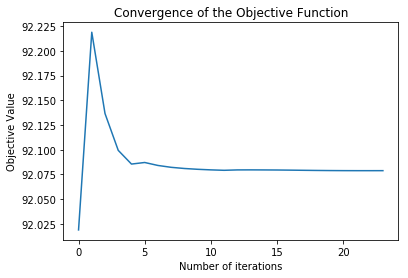

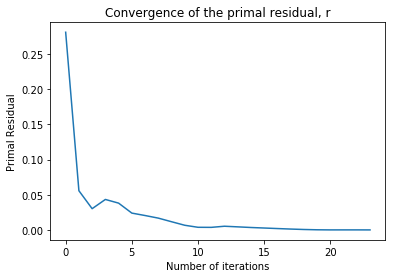

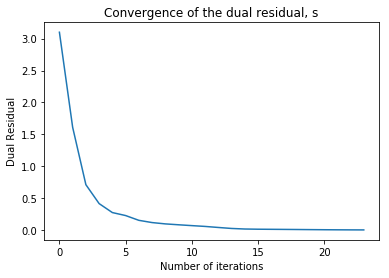

In [9]:
plt.plot(Obj)
plt.title('Convergence of the Objective Function')
plt.xlabel('Number of iterations')
plt.ylabel('Objective Value')
plt.show()

plt.plot(R)
plt.title('Convergence of the primal residual, r')
plt.xlabel('Number of iterations')
plt.ylabel('Primal Residual')
plt.show()

plt.plot(S)
plt.title('Convergence of the dual residual, s')
plt.xlabel('Number of iterations')
plt.ylabel('Dual Residual')
plt.show()


In [13]:
a, b, c = lasso_path(X,Y)
print ("Final lambda for lasso path:", a[-1] * N)

print ("Infinity Norm of difference:", la.norm(b[:,-1] - z1, ord=np.inf))
print ("Euclidean Norm of difference:", la.norm(b[:,-1]-z1))
print ("Mean elementwise difference:", np.abs(b[:,-1] - z1).mean())

Final lambda for lasso path: 0.259210959438
Infinity Norm of difference: 0.0353362926464
Euclidean Norm of difference: 0.08469889846128897
Mean elementwise difference: 0.00643981824305
